# **Lab 02:** Creating your own CNN with PyTorch

### **General Instructions**

- In this lab, you'll create your own CNN in order to surpass an accuracy of 70% on CIFAR-10.

### **System Diagram Requirement**

You must include a **diagram of your system pipeline** showing the CNN architecture.

This diagram is **required** to understand your model logic.

You can draw it digitally, use any Pyhton library, or by hand and include an image.

If your diagram was created assisted by GenAI, also include the `promt` used in the next block. If the generated system diagram is not clear or you cannot interpret it, adjust the prompt as needed or draw it by hand.

*If you used GenAI, write your prompt here..*

### **Load the CIFAR-10 dataset**

In [2]:
# Load the CIFAR-10 dataset here
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print(len(trainset)) 
print(len(testset))   

/home/ariel/Escritorio/proyectos/Computer_Vision/.venv/lib/python3.12/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


50000
10000


In [3]:
classes = trainset.classes
num_classes = len(classes)

print(f"Número de clases: {num_classes}")
print(f"Nombres de las clases: {classes}")

Número de clases: 10
Nombres de las clases: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


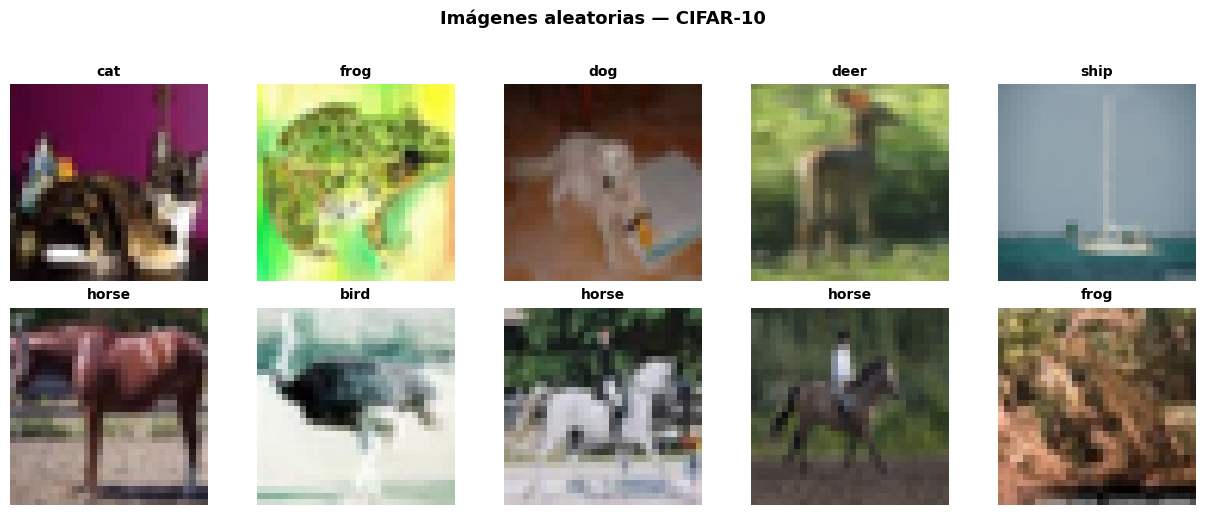

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import random

def show_random_images(dataset, classes, n=10):
    indices = random.sample(range(len(dataset)), n)
    
    cols = 5
    rows = (n + cols - 1) // cols  # filas necesarias
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Des-normalizar: de [-1,1] a [0,1]
        img = image / 2 + 0.5
        img = np.transpose(img.numpy(), (1, 2, 0))  # (C,H,W) → (H,W,C)
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(classes[label], fontsize=10, fontweight="bold")
        axes[i].axis("off")
    
    # Ocultar ejes sobrantes si n no es múltiplo de cols
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")
    
    plt.suptitle("Imágenes aleatorias — CIFAR-10", fontsize=13, fontweight="bold", y=1.02)
    plt.tight_layout()
    plt.show()


# Llamar la función
show_random_images(trainset, classes, n=10)

### **Create your CNN with PyTorch and train it on the CIFAR-10 dataset**

In [13]:
# Create your own CNN using PyTorch and train it on the CIFAR-10 dataset
from torch import nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self, num_chanels, num_classes):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=num_chanels, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(in_features=32*4*4, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=num_classes)

    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [14]:
from torch import optim
device = "cuda"
model = CNN(num_chanels=3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
from tqdm import tqdm

num_epochs = 50 # 50 pueden ser muchos si no tienes GPU, prueba con 10 primero
for epoch in range(num_epochs):
    losses = []
    num_correct = 0
    num_samples = 0
    
    # Configuramos tqdm con un diseño más limpio
    loop = tqdm(enumerate(trainloader), total=len(trainloader), leave=True)
    
    for batch_idx, (data, targets) in loop:
        # Enviar a dispositivo (GPU o CPU)
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)
        losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calcular Accuracy en tiempo real
        _, predictions = scores.max(1)
        num_correct += (predictions == targets).sum()
        num_samples += predictions.size(0)
        current_acc = float(num_correct) / num_samples

        # Actualizar la barra de progreso de tqdm
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        loop.set_postfix(loss=loss.item(), acc=f"{current_acc*100:.2f}%")

    # Al final del epoch puedes imprimir el promedio
    print(f"-> Epoch {epoch+1} finalizado. Loss promedio: {sum(losses)/len(losses):.4f}")

Epoch [1/50]: 100%|██████████| 1563/1563 [00:11<00:00, 138.75it/s, acc=40.45%, loss=1.15] 


-> Epoch 1 finalizado. Loss promedio: 1.6274


Epoch [2/50]: 100%|██████████| 1563/1563 [00:10<00:00, 143.01it/s, acc=51.89%, loss=1.55] 


-> Epoch 2 finalizado. Loss promedio: 1.3271


Epoch [3/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.67it/s, acc=57.49%, loss=0.841]


-> Epoch 3 finalizado. Loss promedio: 1.1823


Epoch [4/50]: 100%|██████████| 1563/1563 [00:10<00:00, 142.55it/s, acc=61.52%, loss=0.817]


-> Epoch 4 finalizado. Loss promedio: 1.0774


Epoch [5/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.69it/s, acc=64.35%, loss=0.784]


-> Epoch 5 finalizado. Loss promedio: 1.0049


Epoch [6/50]: 100%|██████████| 1563/1563 [00:10<00:00, 142.27it/s, acc=66.07%, loss=0.986]


-> Epoch 6 finalizado. Loss promedio: 0.9606


Epoch [7/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.71it/s, acc=67.55%, loss=0.353]


-> Epoch 7 finalizado. Loss promedio: 0.9161


Epoch [8/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.30it/s, acc=69.10%, loss=0.686]


-> Epoch 8 finalizado. Loss promedio: 0.8836


Epoch [9/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.64it/s, acc=69.77%, loss=1.55] 


-> Epoch 9 finalizado. Loss promedio: 0.8524


Epoch [10/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.20it/s, acc=70.69%, loss=0.702]


-> Epoch 10 finalizado. Loss promedio: 0.8325


Epoch [11/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.32it/s, acc=71.45%, loss=1.1]  


-> Epoch 11 finalizado. Loss promedio: 0.8068


Epoch [12/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.48it/s, acc=72.26%, loss=1.17] 


-> Epoch 12 finalizado. Loss promedio: 0.7868


Epoch [13/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.59it/s, acc=72.72%, loss=0.425]


-> Epoch 13 finalizado. Loss promedio: 0.7737


Epoch [14/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.41it/s, acc=73.32%, loss=0.909]


-> Epoch 14 finalizado. Loss promedio: 0.7524


Epoch [15/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.75it/s, acc=73.53%, loss=0.653]


-> Epoch 15 finalizado. Loss promedio: 0.7361


Epoch [16/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.53it/s, acc=74.14%, loss=0.674]


-> Epoch 16 finalizado. Loss promedio: 0.7234


Epoch [17/50]: 100%|██████████| 1563/1563 [00:11<00:00, 139.82it/s, acc=74.57%, loss=0.84] 


-> Epoch 17 finalizado. Loss promedio: 0.7091


Epoch [18/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.26it/s, acc=75.16%, loss=1.23] 


-> Epoch 18 finalizado. Loss promedio: 0.6938


Epoch [19/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.35it/s, acc=75.41%, loss=1.19] 


-> Epoch 19 finalizado. Loss promedio: 0.6849


Epoch [20/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.88it/s, acc=75.57%, loss=1.32] 


-> Epoch 20 finalizado. Loss promedio: 0.6765


Epoch [21/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.08it/s, acc=76.22%, loss=0.564]


-> Epoch 21 finalizado. Loss promedio: 0.6596


Epoch [22/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.09it/s, acc=76.33%, loss=0.583]


-> Epoch 22 finalizado. Loss promedio: 0.6561


Epoch [23/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.77it/s, acc=76.41%, loss=0.822]


-> Epoch 23 finalizado. Loss promedio: 0.6518


Epoch [24/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.87it/s, acc=76.78%, loss=0.55] 


-> Epoch 24 finalizado. Loss promedio: 0.6437


Epoch [25/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.38it/s, acc=77.18%, loss=0.774]


-> Epoch 25 finalizado. Loss promedio: 0.6299


Epoch [26/50]: 100%|██████████| 1563/1563 [00:10<00:00, 142.64it/s, acc=77.38%, loss=0.723]


-> Epoch 26 finalizado. Loss promedio: 0.6235


Epoch [27/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.56it/s, acc=77.27%, loss=0.392]


-> Epoch 27 finalizado. Loss promedio: 0.6205


Epoch [28/50]: 100%|██████████| 1563/1563 [00:10<00:00, 143.47it/s, acc=77.64%, loss=0.864]


-> Epoch 28 finalizado. Loss promedio: 0.6130


Epoch [29/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.71it/s, acc=78.11%, loss=0.463]


-> Epoch 29 finalizado. Loss promedio: 0.6011


Epoch [30/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.90it/s, acc=77.99%, loss=0.324]


-> Epoch 30 finalizado. Loss promedio: 0.5974


Epoch [31/50]: 100%|██████████| 1563/1563 [00:11<00:00, 139.76it/s, acc=77.94%, loss=0.9]  


-> Epoch 31 finalizado. Loss promedio: 0.5960


Epoch [32/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.92it/s, acc=78.66%, loss=0.524]


-> Epoch 32 finalizado. Loss promedio: 0.5835


Epoch [33/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.91it/s, acc=78.90%, loss=0.553]


-> Epoch 33 finalizado. Loss promedio: 0.5787


Epoch [34/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.82it/s, acc=78.86%, loss=0.324]


-> Epoch 34 finalizado. Loss promedio: 0.5767


Epoch [35/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.91it/s, acc=79.22%, loss=0.482]


-> Epoch 35 finalizado. Loss promedio: 0.5691


Epoch [36/50]: 100%|██████████| 1563/1563 [00:10<00:00, 142.79it/s, acc=78.81%, loss=0.656]


-> Epoch 36 finalizado. Loss promedio: 0.5704


Epoch [37/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.79it/s, acc=79.37%, loss=0.618]


-> Epoch 37 finalizado. Loss promedio: 0.5630


Epoch [38/50]: 100%|██████████| 1563/1563 [00:10<00:00, 142.59it/s, acc=79.30%, loss=0.445]


-> Epoch 38 finalizado. Loss promedio: 0.5563


Epoch [39/50]: 100%|██████████| 1563/1563 [00:10<00:00, 142.29it/s, acc=79.52%, loss=0.806]


-> Epoch 39 finalizado. Loss promedio: 0.5501


Epoch [40/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.01it/s, acc=79.68%, loss=0.631]


-> Epoch 40 finalizado. Loss promedio: 0.5445


Epoch [41/50]: 100%|██████████| 1563/1563 [00:11<00:00, 139.77it/s, acc=79.67%, loss=0.395]


-> Epoch 41 finalizado. Loss promedio: 0.5430


Epoch [42/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.57it/s, acc=79.81%, loss=0.557]


-> Epoch 42 finalizado. Loss promedio: 0.5425


Epoch [43/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.48it/s, acc=80.25%, loss=0.316]


-> Epoch 43 finalizado. Loss promedio: 0.5335


Epoch [44/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.01it/s, acc=80.06%, loss=0.307]


-> Epoch 44 finalizado. Loss promedio: 0.5339


Epoch [45/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.63it/s, acc=80.20%, loss=0.216]


-> Epoch 45 finalizado. Loss promedio: 0.5280


Epoch [46/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.37it/s, acc=80.42%, loss=0.464]


-> Epoch 46 finalizado. Loss promedio: 0.5213


Epoch [47/50]: 100%|██████████| 1563/1563 [00:11<00:00, 141.31it/s, acc=80.65%, loss=0.554]


-> Epoch 47 finalizado. Loss promedio: 0.5177


Epoch [48/50]: 100%|██████████| 1563/1563 [00:11<00:00, 140.83it/s, acc=80.79%, loss=0.549]


-> Epoch 48 finalizado. Loss promedio: 0.5192


Epoch [49/50]: 100%|██████████| 1563/1563 [00:11<00:00, 139.91it/s, acc=80.66%, loss=0.0529]


-> Epoch 49 finalizado. Loss promedio: 0.5157


Epoch [50/50]: 100%|██████████| 1563/1563 [00:10<00:00, 143.31it/s, acc=80.78%, loss=0.626]

-> Epoch 50 finalizado. Loss promedio: 0.5163


In [5]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando: {device}")

model = nn.Sequential(
    # Bloque 1
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                         # 32x32 → 16x16

    # Bloque 2
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                         # 16x16 → 8x8

    # Bloque 3
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),                         # 8x8 → 4x4

    # Flatten + Fully Connected
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10)                          # 10 clases
).to(device)

Usando: cuda


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [7]:
EPOCHS = 30
train_losses, train_accs = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total   += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    scheduler.step()

    epoch_loss = running_loss / len(trainloader)
    epoch_acc  = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Epoch [{epoch+1:02d}/{EPOCHS}]  Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.2f}%")

print("\n✅ Entrenamiento finalizado!")

Epoch [01/30]  Loss: 1.3441  Acc: 51.65%
Epoch [02/30]  Loss: 1.0053  Acc: 64.80%
Epoch [03/30]  Loss: 0.8694  Acc: 69.64%
Epoch [04/30]  Loss: 0.7714  Acc: 73.12%
Epoch [05/30]  Loss: 0.6950  Acc: 75.93%
Epoch [06/30]  Loss: 0.6261  Acc: 78.18%
Epoch [07/30]  Loss: 0.5733  Acc: 80.13%
Epoch [08/30]  Loss: 0.5221  Acc: 81.89%
Epoch [09/30]  Loss: 0.4750  Acc: 83.43%
Epoch [10/30]  Loss: 0.4442  Acc: 84.44%
Epoch [11/30]  Loss: 0.3322  Acc: 88.35%
Epoch [12/30]  Loss: 0.2943  Acc: 89.51%
Epoch [13/30]  Loss: 0.2639  Acc: 90.62%
Epoch [14/30]  Loss: 0.2479  Acc: 91.18%
Epoch [15/30]  Loss: 0.2260  Acc: 91.83%
Epoch [16/30]  Loss: 0.2132  Acc: 92.34%
Epoch [17/30]  Loss: 0.2002  Acc: 92.81%
Epoch [18/30]  Loss: 0.1876  Acc: 93.16%
Epoch [19/30]  Loss: 0.1783  Acc: 93.54%
Epoch [20/30]  Loss: 0.1657  Acc: 94.04%
Epoch [21/30]  Loss: 0.1241  Acc: 95.58%
Epoch [22/30]  Loss: 0.1070  Acc: 96.20%
Epoch [23/30]  Loss: 0.1011  Acc: 96.37%
Epoch [24/30]  Loss: 0.0953  Acc: 96.60%
Epoch [25/30]  L

### **Evaluate the accuracy of your CNN (must be >= 70%)**

In [8]:
model.eval()
correct, total = 0, 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total   += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print(f"Accuracy en Test: {100 * correct / total:.2f}%")

Accuracy en Test: 80.59%


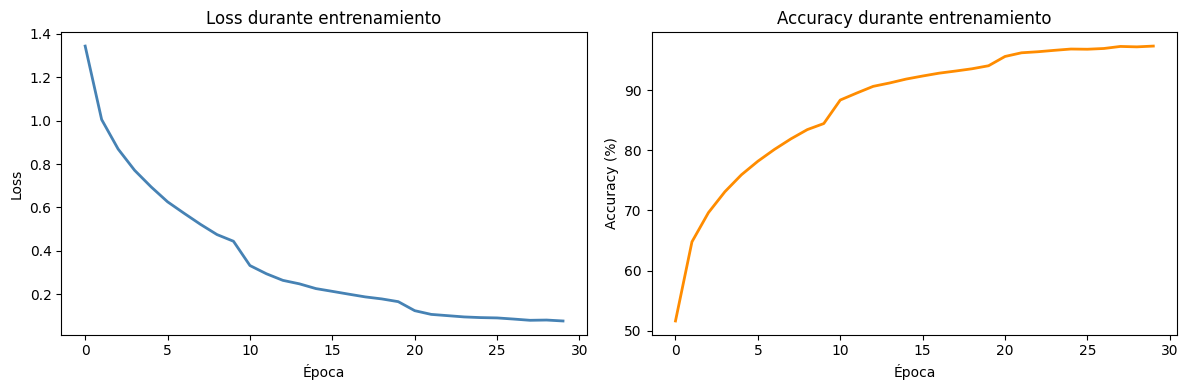

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, color="steelblue", linewidth=2)
ax1.set_title("Loss durante entrenamiento")
ax1.set_xlabel("Época"); ax1.set_ylabel("Loss")

ax2.plot(train_accs, color="darkorange", linewidth=2)
ax2.set_title("Accuracy durante entrenamiento")
ax2.set_xlabel("Época"); ax2.set_ylabel("Accuracy (%)")

plt.tight_layout()
plt.show()

### **System Diagram**

Insert your system diagram below (image or drawing). It must clearly show:

- Number of convolutional layers  
- Kernel size(s)
- Pooling layers (if any)  
- etc..  

# Insert or display your system diagram image here
![Descripción](diagrama_manu.png)

### **Written Analysis Questions**

### 1. Why increasing depth could improve performance

Increasing the number of layers allows the network to learn **hierarchical representations** of increasing complexity:

- **Shallow layers** detect low-level features: edges, corners, and color gradients.
- **Middle layers** combine those into textures and shapes.
- **Deep layers** recognize high-level concepts like "a cat's ear", "a wheel", or "a wing".

For CIFAR-10, a 3-block CNN can distinguish broad shapes, but adding more convolutional layers gives the network more capacity to separate visually similar classes (e.g., *cat* vs *dog*, *automobile* vs *truck*). Each extra layer adds a non-linear transformation that expands the **decision boundary** in feature space.

---

### 2. Under what conditions deeper networks may hurt performance

Depth is not always beneficial. It can hurt when:

- **The dataset is small:** more parameters lead to overfitting — the model memorizes instead of generalizing.
- **Vanishing gradients occur:** without BatchNorm or residual connections, gradients shrink layer by layer and early layers stop learning.
- **Regularization is missing:** deep networks without Dropout or weight decay easily overfit.
- **The input resolution is too small:** CIFAR-10 images are 32×32. After 4+ pooling layers, the spatial map collapses to 1×1, destroying spatial information.
- **Compute is limited:** training time grows significantly and becomes impractical without a GPU.

---

### 3. How could dropout, batch normalization, or data augmentation help?

**Batch Normalization:**
- Normalizes activations within each mini-batch, stabilizing training.
- Reduces sensitivity to weight initialization.
- Acts as a mild regularizer, allowing higher learning rates.
- *Effect:* faster convergence and a more stable loss curve.

**Dropout:**
- During training, randomly sets neurons to zero with probability `p`.
- Forces the network to not rely on any single neuron, promoting redundant representations.
- *Effect:* reduces overfitting, especially in fully-connected layers.

**Data Augmentation:**
- Artificially expands the training set by applying transforms such as:
  - `RandomHorizontalFlip` — a car flipped horizontally is still a car.
  - `RandomCrop` — teaches position invariance.
  - `ColorJitter` — teaches robustness to lighting changes.
- *Effect:* the model sees more diverse examples without collecting new data, directly reducing overfitting.

Together, these three techniques form the **standard regularization toolkit** for modern CNNs.

---

### 4. How would you determine whether your CNN is overfitting or underfitting?

Compare **training accuracy** vs **test accuracy** over epochs:

- If **both are low** → the model is **underfitting**. It is too simple or has not trained long enough.
- If **training accuracy is high but test accuracy is much lower** → the model is **overfitting**. There is a large generalization gap.
- If **both are high and close to each other** → the model has a **good fit**.

**Signs of underfitting:**
- Both losses remain high after many epochs.
- *Fix:* add more layers, train longer, or reduce regularization.

**Signs of overfitting:**
- Train loss keeps decreasing but **test loss starts increasing**.
- *Fix:* add Dropout, BatchNorm, data augmentation, reduce model size, or use early stopping.

---

### 5. Which architectural components most impact computational cost?

- **Conv2d layers** are the most expensive. Their cost grows with kernel size, number of filters, and the spatial resolution of the feature map. The first convolutional layer on the full 32×32 input is usually the single most expensive operation.
- **MaxPool2d** is cheap but reduces height and width by half, which lowers the cost of all subsequent layers significantly.
- **Linear (Fully Connected) layers** can be expensive when the input is large (e.g., 2048 features × 256 neurons).
- **BatchNorm** only computes per-channel statistics, making it very cheap.
- **Dropout** has zero cost at inference time since it is only active during training.

Applying pooling early is key to keeping the overall computation manageable.

---

### 6. Whether the accuracy gain justifies the added complexity in a real-world deployment scenario

The answer always depends on the deployment context:

- **Edge devices** (Raspberry Pi, smartphones): prefer a shallow, lightweight model. A 5% accuracy drop may be worth 10× less latency and RAM usage.
- **Real-time systems** (autonomous vehicles, robotics): latency is critical. Accuracy must be high but the model must be fast — efficient architectures like MobileNet or EfficientNet are preferred.
- **Cloud APIs** (batch processing, medical imaging): compute is cheap, so a deeper, more accurate model is justified.
- **Safety-critical embedded systems**: simpler and more interpretable models are often preferred due to regulatory and reliability constraints.

**General rule:** always benchmark accuracy vs inference time vs memory footprint. A model that is 2% more accurate but 5× slower may not be worth deploying. The right trade-off is always **context-dependent**.


## **Grading Rubric (10 points)**

| Criterion | Points |
|------------|--------|
| **Baseline Reproduction** – Correct implementation and training of the provided baseline CNN. Clear report of baseline accuracy and training setup. | 1 |
| **Architectural Modifications** – Meaningful and technically justified changes to the CNN architecture (e.g., depth, kernel size, normalization, dropout, residual connections). Changes must go beyond trivial parameter tuning. | 2 |
| **Written Architectural Justification** – Clear explanation of *why* the chosen modifications should improve performance (receptive field, feature hierarchy, regularization, gradient flow, etc.). | 2 |
| **Experimental Design & Comparison** – Systematic comparison between baseline and modified model (same dataset split, controlled variables, reported metrics). Includes training/validation accuracy curves. | 2 |
| **Performance Improvement** – Modified architecture surpasses baseline validation/test accuracy. <br>• +1% improvement: 0.5 pts <br>• +2% improvement: 1 pt | 1 |
| **Generalization Analysis** – Discussion of overfitting/underfitting behavior and the role of regularization techniques (BatchNorm, Dropout, data augmentation, etc.). | 1 |
| **Computational Tradeoff Reflection** – Analysis of parameter count, training time, and whether the accuracy gain justifies the added complexity. | 1 |
| **Code Clarity & PyTorch Best Practices** – Clean modular implementation (proper use of `nn.Module`, readable forward pass, reproducibility practices). | 1 |
| **Total** | **10** |

---

### Notes

- Simply increasing the number of filters without justification will not receive full architectural credit.
- Accuracy alone does not guarantee a high grade — reasoning and analysis are weighted heavily.
- Extra credit (+0.5) may be awarded for implementing advanced concepts (e.g., residual blocks, learning rate scheduling experiments, or ablation studies). Applies just for students with <10 points.

---

<p style="text-align: right; font-size:14px; color:gray;">
<b>Prepared by:</b><br>
Manuel Eugenio Morocho-Cayamcela
</p>